In [582]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator


In [583]:
libs = ['SRR1197125','SRR1197126','SRR1197127','SRR1197128']
path_annotation = '/home/juan/Desktop/juan/bio/data/IWGSC/42/Triticum_aestivum.IWGSC.42.gff3'
path_libs = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/sun_deg/%s'
path_transcripts = '/home/juan/Desktop/juan/bio/mirna_mite/data/fixed.cdna.all.fa'
path_transcripts_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/targets.fa'
path_blast_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/transcripts_mites.csv'
path_mirna_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.csv'
path_res_final = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/res_deg.csv'
path_ann = '/home/juan/Desktop/juan/bio/data/IWGSC/42/Triticum_aestivum.IWGSC.42.gff3'

In [585]:
dfs = []
for lib in libs:
    path_lib = path_libs % lib
    df = pd.read_csv(path_lib, sep='\t',comment='#')
    df['lib'] = lib
    dfs.append(df)


In [586]:
df = pd.concat(dfs)
print(len(df.index))

15313


In [587]:
df.drop_duplicates(['SiteID','Query'], inplace=True)
print(len(df.index))

13480


In [588]:
print(len(df[df.DegradomeCategory == 0].index))

408


In [589]:
df.head(2)

,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib
0,TraesCS1A02G000300.1:66,sun_all_Cluster_118867,TraesCS1A02G000300.1,54,75,66,-43.6,-28.4,0.651376,9.0,"1-2,75-74;5-11,71-65;13-14,63-62;16-22,60-54","3-4,73-72[SIL];12-12,64-64[SIL];15-15,61-61[SIL]",(((((((.((.(((((((..((&))..))))))).)).))))))),GCAGAUCUUGGUGGUAGUAGCA&UGAAGCUGCCAGCAUGAUCUGC,3,0.951576,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125
1,TraesCS1A02G000400.1:1381,sun_all_Cluster_118867,TraesCS1A02G000400.1,1369,1390,1381,-43.6,-28.4,0.651376,9.0,"1-2,1390-1389;5-11,1386-1380;13-14,1378-1377;1...","3-4,1388-1387[SIL];12-12,1379-1379[SIL];15-15,...",(((((((.((.(((((((..((&))..))))))).)).))))))),GCAGAUCUUGGUGGUAGUAGCA&UGAAGCUGCCAGCAUGAUCUGC,3,0.955557,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125


In [590]:
transcripts = set()
for k,v in df.iterrows():
    transcript = v.Transcript
    transcripts.add(transcript)

In [591]:
fasta_seq = SeqIO.parse(path_transcripts, 'fasta')


In [592]:
lens = {}
buffer_seqs = []
for record in fasta_seq:
    if record.id in transcripts:
        buffer_seqs.append(record)
        clean_seq = ''.join(str(record.seq).splitlines())
        lens[record.id] = len(clean_seq)
SeqIO.write(buffer_seqs, path_transcripts_res, "fasta")
print(path_transcripts_res)

/home/juan/Desktop/juan/bio/mirna_mite/data/res/targets.fa


In [594]:
df_mites = pd.read_csv(path_blast_res, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_mites.columns = cols
df_mites = df_mites[df_mites.pident >= 85]
df_mites = df_mites[df_mites.qcovs >= 85]
print(len(df_mites.index))
df_mites.head(2)

10223


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,MITE_0,TraesCS5D02G132100.1,1,80,479,399,6,1,91.358,3.380000e-25,81,80,2089,100,122
1,MITE_0,TraesCS5B02G114400.1,1,80,2097,2177,6,1,91.358,3.380000e-25,81,80,2243,100,122


In [595]:
df['new_start'] = df[['TStart','TStop']].min(axis=1)
df['new_end'] = df[['TStart','TStop']].max(axis=1)
df['TStart'] = df['new_start']
df['TStop'] = df['new_end']
df = df.drop('new_start',axis=1).drop('new_end',axis=1)


In [557]:
df_mites['new_start'] = df_mites[['sstart','send']].min(axis=1)
df_mites['new_end'] = df_mites[['sstart','send']].max(axis=1)
df_mites['sstart'] = df_mites['new_start']
df_mites['send'] = df_mites['new_end']
df_mites = df_mites.drop('new_start',axis=1).drop('new_end',axis=1)


In [558]:
df['MITE'] = ''

In [599]:
df_mites.loc[df_mites['score'].idxmax()].qseqid

'MITE_1095'

In [600]:
for k,v in df.iterrows():
    start = v.TStart
    end = v.TStop
    transcript = v.Transcript
    df_filter = df_mites[df_mites.sseqid==transcript]
    df_filter = df_filter[(df_filter.sstart <= start) & (df_filter.send >= end)]
    if len(df_filter.index) > 0:
        df.at[k, 'MITE'] = df_filter.loc[df_filter['score'].idxmax()].qseqid        

In [604]:
total = len(df.index)
w_mites = len(df[df.MITE.notnull()].index)
w_o_mites = len(df[df.MITE.isnull()].index)
print('Total', total)
print('W mites', w_mites)
print('WO mites', w_o_mites)
print(w_mites * 100 / total)

Total 13480
W mites 1144
WO mites 12336
8.486646884272997


In [606]:
df.head(2)

,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,MITE
0,TraesCS1A02G000300.1:66,sun_all_Cluster_118867,TraesCS1A02G000300.1,54,75,66,-43.6,-28.4,0.651376,9.0,"1-2,75-74;5-11,71-65;13-14,63-62;16-22,60-54","3-4,73-72[SIL];12-12,64-64[SIL];15-15,61-61[SIL]",(((((((.((.(((((((..((&))..))))))).)).))))))),GCAGAUCUUGGUGGUAGUAGCA&UGAAGCUGCCAGCAUGAUCUGC,3,0.951576,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125,NaN
1,TraesCS1A02G000400.1:1381,sun_all_Cluster_118867,TraesCS1A02G000400.1,1369,1390,1381,-43.6,-28.4,0.651376,9.0,"1-2,1390-1389;5-11,1386-1380;13-14,1378-1377;1...","3-4,1388-1387[SIL];12-12,1379-1379[SIL];15-15,...",(((((((.((.(((((((..((&))..))))))).)).))))))),GCAGAUCUUGGUGGUAGUAGCA&UGAAGCUGCCAGCAUGAUCUGC,3,0.955557,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125,NaN


In [607]:
#add annotations

In [608]:
df_ann = pd.read_csv(path_annotation, index_col=False, sep='\t', comment='#', header=None)
df_ann.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']
print(len(df_ann.index))

1957744


In [609]:
df_ann.head(1)

,seqname,source,feature,start,end,score,strand,frame,attribute
0,1A,International Wheat Genome Sequencing Consortium,chromosome,1,594102056,.,.,.,"ID=chromosome:1A;Alias=chr1A,LS992080.1"


In [610]:
df_ann['feature_len'] = abs(df_ann['start'] - df_ann['end'])


In [611]:
df_ann = df_ann[
    (df_ann.feature == 'three_prime_UTR') | 
    (df_ann.feature == 'five_prime_UTR')]
print(len(df_ann.index))


216091


In [612]:
df_ann = df_ann.reset_index(drop=True)


In [613]:
df_ann['transcript'] = df_ann['attribute'].str.split('transcript:').str[1]
df_ann['transcript'] = df_ann['transcript'].str.split(';').str[0]

In [614]:
df_ann.head(5)

,seqname,source,feature,start,end,score,strand,frame,attribute,feature_len,transcript
0,1A,IWGSC,three_prime_UTR,40098,40731,.,-,.,Parent=transcript:TraesCS1A02G000100.1,633,TraesCS1A02G000100.1
1,1A,IWGSC,three_prime_UTR,58474,58507,.,-,.,Parent=transcript:TraesCS1A02G000100.1,33,TraesCS1A02G000100.1
2,1A,IWGSC,five_prime_UTR,58769,58897,.,-,.,Parent=transcript:TraesCS1A02G000100.1,128,TraesCS1A02G000100.1
3,1A,IWGSC,five_prime_UTR,70089,70338,.,-,.,Parent=transcript:TraesCS1A02G000100.1,249,TraesCS1A02G000100.1
4,1A,IWGSC,three_prime_UTR,70557,70650,.,+,.,Parent=transcript:TraesCS1A02G000200.1,93,TraesCS1A02G000200.1


In [615]:
indexes = df_ann[(df_ann.strand=='+') & (df_ann.feature=='five_prime_UTR')].duplicated(['feature','transcript'],keep='first')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]

indexes = df_ann[(df_ann.strand=='-') & (df_ann.feature=='five_prime_UTR')].duplicated(['feature','transcript'],keep='last')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]


indexes = df_ann[(df_ann.strand=='+') & (df_ann.feature=='three_prime_UTR')].duplicated(['feature','transcript'],keep='last')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]

indexes = df_ann[(df_ann.strand=='-') & (df_ann.feature=='three_prime_UTR')].duplicated(['feature','transcript'],keep='first')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]



In [616]:
print(len(df_ann.index))
df_ann.head(5)

180799


,seqname,source,feature,start,end,score,strand,frame,attribute,feature_len,transcript
0,1A,IWGSC,three_prime_UTR,40098,40731,.,-,.,Parent=transcript:TraesCS1A02G000100.1,633,TraesCS1A02G000100.1
3,1A,IWGSC,five_prime_UTR,70089,70338,.,-,.,Parent=transcript:TraesCS1A02G000100.1,249,TraesCS1A02G000100.1
5,1A,IWGSC,three_prime_UTR,88242,89245,.,+,.,Parent=transcript:TraesCS1A02G000200.1,1003,TraesCS1A02G000200.1
6,1A,IWGSC,five_prime_UTR,95906,96020,.,+,.,Parent=transcript:TraesCS1A02G000300.1,114,TraesCS1A02G000300.1
8,1A,IWGSC,five_prime_UTR,102794,104077,.,+,.,Parent=transcript:TraesCS1A02G000400.1,1283,TraesCS1A02G000400.1


In [617]:
df['annotation'] = ''

In [618]:
for k,v in df.iterrows():
    transcript_start = v.TStart
    transcript_stop = v.TStop
    transcript_slice = v.TSlice
    transcript_name = v.Transcript
    transcript_len = lens[transcript_name]
    other = df_ann[df_ann.transcript == transcript_name]
    for k2,v2 in other.iterrows():
        if v2.feature == 'five_prime_UTR' and v2.strand == '+' and transcript_slice <= v2.feature_len:
             df.loc[k, 'annotation'] = 'five_prime_UTR'
        if v2.feature == 'five_prime_UTR' and v2.strand == '-' and transcript_len - transcript_slice <= v2.feature_len:
             df.loc[k, 'annotation'] = 'five_prime_UTR'
        if v2.feature == 'three_prime_UTR' and v2.strand == '+' and transcript_slice >= transcript_len - v2.feature_len:
             df.loc[k, 'annotation'] = 'three_prime_UTR'
        if v2.feature == 'three_prime_UTR' and v2.strand == '-' and transcript_slice <= v2.feature_len:
             df.loc[k, 'annotation'] = 'three_prime_UTR'


In [619]:
df_ann[df_ann.transcript=='TraesCS1A02G001400.1']

,seqname,source,feature,start,end,score,strand,frame,attribute,feature_len,transcript
20,1A,IWGSC,three_prime_UTR,294611,295669,.,-,.,Parent=transcript:TraesCS1A02G001400.1,1058,TraesCS1A02G001400.1
22,1A,IWGSC,five_prime_UTR,304348,305428,.,-,.,Parent=transcript:TraesCS1A02G001400.1,1080,TraesCS1A02G001400.1


In [620]:
df['annotation'].fillna('exon', inplace=True)

In [621]:
df['annotation'].replace('', 'exon',inplace=True)

In [622]:
df[['SiteID','annotation']].head(10)

,SiteID,annotation
0,TraesCS1A02G000300.1:66,three_prime_UTR
1,TraesCS1A02G000400.1:1381,exon
2,TraesCS1A02G000600.1:14,exon
3,TraesCS1A02G000900.1:1117,three_prime_UTR
4,TraesCS1A02G001000.1:1547,five_prime_UTR
5,TraesCS1A02G001100.1:3677,three_prime_UTR
6,TraesCS1A02G001100.1:933,five_prime_UTR
7,TraesCS1A02G001400.1:1787,five_prime_UTR
8,TraesCS1A02G001400.1:649,five_prime_UTR
9,TraesCS1A02G004200.1:338,three_prime_UTR


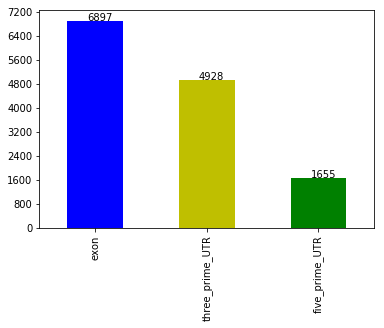

In [623]:
ax = df.annotation.value_counts().plot('bar',color=['b','y','g'])
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
#pyplot.savefig('../data/res/1.png',transparent=True, bbox_inches='tight', pad_inches=0)

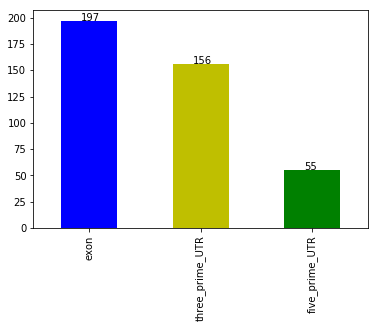

In [624]:
ax = df[df.DegradomeCategory == 0].annotation.value_counts().plot('bar',color=['b','y','g'])
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
#pyplot.savefig('../data/res/1.png',transparent=True, bbox_inches='tight', pad_inches=0)

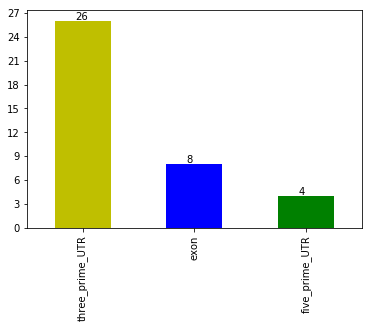

In [633]:
ax = df[(df.DegradomeCategory == 0) & (df.MITE.notnull())].annotation.value_counts().plot('bar',color=['y','b','g'])

x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax

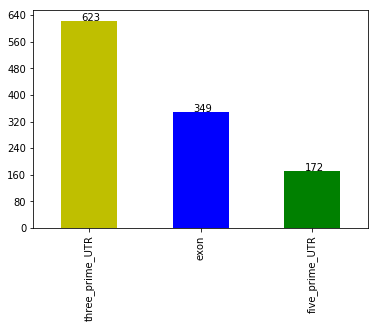

In [630]:
ax = df[df.MITE.notnull()].annotation.value_counts().plot('bar',color=['y','b','g'])

x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax


In [631]:
df.to_csv(path_res_final, index=None)
path_res_final

'/home/juan/Desktop/juan/bio/mirna_mite/data/res/res_deg.csv'

In [ ]:
df_mites = df[df.MITE != '']
df[df.MITE != ''][['SiteID','Query','Transcript','TStart','TStop','MITE','Sequence']].head()

In [ ]:
df_mirna_res = pd.read_csv(path_mirna_res, sep='\t')
df_mirna_res.rename(columns={'MITE':'MITE_prod'}, inplace=True)
print(len(df_mirna_res.index))
df_mirna_res.head(2)

In [ ]:
df_mirna_res_mites = df_mirna_res[df_mirna_res.MITE_prod.notnull()]
print(len(df_mirna_res_mites.index))


In [ ]:
df_mirna_res_mites['Name'] = df_mirna_res_mites.Name.str.split("|").str[0]

In [ ]:
df_mirna_res_mites_for_merge = df_mirna_res_mites[['Name','#Locus','MajorRNA','MITE_prod']]

In [ ]:
df_merge = pd.merge(df_mites,df_mirna_res_mites,left_on='Query', right_on='Name')

In [ ]:
df_new = df_merge[['SiteID','DegradomeCategory','Name','#Locus','MajorRNA','MITE','MITE_prod']]

In [ ]:
df_merge.head(2)

In [ ]:
df_merge['equal_mite'] = 0
for k,v in df_merge.iterrows():
    prods = v.MITE_prod.split(',')
    target = v.MITE.split(',')
    prods = set(filter(None, prods))
    target = set(filter(None, target))
    inter = target.intersection(prods)
    if inter:
        print(v.SiteID, v.Name, inter)
        df_merge.at[k, 'equal_mite'] = 1

In [ ]:
df_merge[df_merge.Name=='sun_all_Cluster_8835']

In [ ]:
total_ele = len(df_merge.index)
equal_mite = len(df_merge[df_merge.equal_mite==1].index)
print(equal_mite * 100 /total_ele)

In [ ]:
df_merge.to_csv(path_res_final, index=None)
path_res_final